In [ ]:
import sys

!test -d or-gym || git clone https://github.com/hubbs5/or-gym.git or-gym
if not 'or-gym' in sys.path:
    sys.path += ['or-gym']

!cd or-gym && pip install -q --editable .

In [ ]:
from scipy.optimize import minimize
import or_gym
import numpy as np

In [ ]:
def base_stock_policy(policy, env):
    '''
    Implements a re-order up-to policy. This means that for
    each node in the network, if the inventory at that node 
    falls below the level denoted by the policy, we will 
    re-order inventory to bring it to the policy level.
    
    For example, policy at a node is 10, current inventory
    is 5: the action is to order 5 units.
    '''
    assert len(policy) == len(env.init_inv), (
        'Policy should match number of nodes in network' + 
        '({}, {}).'.format(
            len(policy), len(env.init_inv)))
    
    # Get echelon inventory levels
    if env.period == 0:
        inv_ech = np.cumsum(env.I[env.period] +
            env.T[env.period])
    else:
        inv_ech = np.cumsum(env.I[env.period] +
            env.T[env.period] - env.B[env.period-1, :-1])
        
    # Get unconstrained actions
    unc_actions = policy - inv_ech
    unc_actions = np.where(unc_actions>0, unc_actions, 0)
    
    # Ensure that actions can be fulfilled by checking 
    # constraints
    inv_const = np.hstack([env.I[env.period, 1:], np.Inf])
    actions = np.minimum(env.c,
                np.minimum(unc_actions, inv_const))
    return actions

In [ ]:
def dfo_func(policy, env, *args):
    '''
    Runs an episode based on current base-stock model 
    settings. This allows us to use our environment for the 
    DFO optimizer.
    '''
    env.reset() # Ensure env is fresh
    rewards = []
    done = False
    while not done:
        action = base_stock_policy(policy, env)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
            
    rewards = np.array(rewards)
    prob = env.demand_dist.pmf(env.D, **env.dist_param)
    
    # Return negative of expected profit
    return -1 / env.num_periods * np.sum(prob * rewards)

In [ ]:
def optimize_inventory_policy(env_name, fun,
    init_policy=None, env_config={}, method='Powell'):
    env = or_gym.make(env_name, env_config=env_config)
    
    if init_policy is None:
        init_policy = np.ones(env.num_stages-1)
        
    # Optimize policy
    out = minimize(fun=fun, x0=init_policy, args=env, 
        method=method)
    policy = out.x.copy()
    
    # Policy must be positive integer
    policy = np.round(np.maximum(policy, 0), 0).astype(int)
    
    return policy, out

In [ ]:
env_name = 'InvManagement-v1'
env_config = {'periods': 50,
          'I0':[100,100,100,200],
          'r':[2.50, 2.00,1.00,0.75,0.50],
          'k':[0.15,0.10,0.075,0.05, 0.025],
          'h':[0.3,0.15,0.10,0.05],
          'c':[130,100,90,80],
          'L':[5,7,10,15],
          'max_rewards':1000}

In [ ]:
policy, out= optimize_inventory_policy(env_name, fun = dfo_func,env_config = env_config)
print("Re-order levels: {}".format(policy))
print("DFO Info:\n{}".format(out))
# Re-order levels: [540 216  81]
# DFO Info:
#    direc: array([[  0.        ,   0.        ,   1.        ],
#        [  0.        ,   1.        ,   0.        ],
#        [206.39353826,  81.74560612,  28.78995703]])
#      fun: -0.9450780368543933
#  message: 'Optimization terminated successfully.'
#     nfev: 212
#      nit: 5
#   status: 0
#  success: True
#        x: array([539.7995151 , 216.38046861,  80.66902905])

Re-order levels: [388 223   0 211]
DFO Info:
   direc: array([[ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 6.19792124,  3.53810173, -0.81314531,  3.38753995]])
     fun: -0.06401864101989349
 message: 'Optimization terminated successfully.'
    nfev: 191
     nit: 3
  status: 0
 success: True
       x: array([387.89076127, 223.23856149, -53.04645016, 211.44254943])


In [ ]:


env = or_gym.make(env_name, env_config=env_config)
eps = 1000
rewards = []
for i in range(eps):
    env.reset()
    reward = 0
    while True:
        action = base_stock_policy(policy, env)
        s, r, done, _ = env.step(action)
        reward += r
        if done:
            rewards.append(reward)
            break



1000


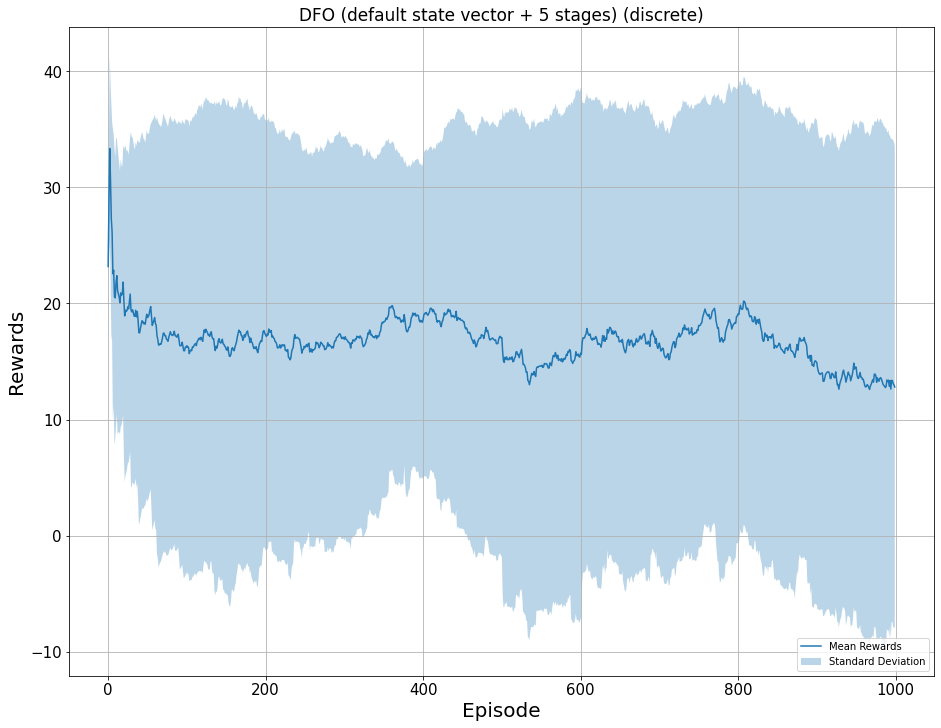

[23.17304170795377, 34.32574229171906, 42.5443707273196, 22.428953169992038, 13.947551796923776, 20.727412193333947, 0.7130734574766016, 24.97139864346994, 2.376151801868759, 19.5275113032788, 34.94767397338692, 29.014955301473464, 5.244540559207065, 17.580310275692916, 16.24785056834205, 13.158063781037555, 34.46821095682617, 17.506833860220883, 23.236503836693053, 40.649318342340116, -12.429151871488385, -8.057767293209544, 30.26885899860633, 16.713593363357983, 22.11660505849335, 27.165650946246032, 14.773920861508946, 36.93015123089236, 39.14614321501607, -19.99418486132477, 13.99608713991218, 25.100248405881143, 11.037647517184363, 9.338299080476403, 18.107408915774226, 37.881920655782054, -1.7700529454808387, 36.45010171616096, -9.957502610935855, -24.274182868686346, 16.545897140150455, 34.591017582103134, 32.42284421060296, 31.55538777410137, 15.65294988223653, 9.258372124989906, 22.101419477201034, 12.38244728653186, 38.269923539865125, 41.16992109862913, 4.95947162524369, 23.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


# Unpack values from each iteration
# rewards = np.hstack([i['hist_stats']['episode_reward'] 
#     for i in results])
print(len(rewards))
# pol_loss = [
#     i['info']['learner']['default_policy']['policy_loss'] for i in results]
# vf_loss = [
#     i['info']['learner']['default_policy']['vf_loss'] 
#     for i in results]
 
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards',fontsize=20)
ax0.set_xlabel('Episode',fontsize=20)
ax0.set_title('DFO (default state vector + 5 stages) (discrete)', fontsize = 17)
ax0.text
ax0.legend(loc = 4)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.grid()
 
# ax1 = fig.add_subplot(gs[0, 2:])
# ax1.plot(pol_loss)
# ax1.set_ylabel('Loss')
# ax1.set_xlabel('Iteration')
# ax1.set_title('Policy Loss')
 
# ax2 = fig.add_subplot(gs[1, 2:])
# ax2.plot(vf_loss)
# ax2.set_ylabel('Loss')
# ax2.set_xlabel('Iteration')
# ax2.set_title('Value Function Loss')

plt.show()

print(rewards)

In [ ]:
with open('Example2.txt', 'w') as writefile:
  for i in rewards:

    writefile.write(str(i))
    writefile.write("\n")